In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split
import torch
import seaborn as sns
from tqdm import tqdm
from time import perf_counter

from nam.wrapper import NAMClassifierDistill, MultiTaskNAMClassifierDistill

C:\Users\satch\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_state = 2016

In [3]:
from tensorflow import keras
# Load the CIFAR-10 dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(-1, 28*28)
test_images = test_images.reshape(-1, 28*28)
train_images.shape

(60000, 784)

In [4]:
def reshape_to_img(inputs):
    return torch.tensor(inputs, requires_grad=False, dtype=torch.float).reshape((-1, 1, 28, 28))

In [5]:
# def select_dataset3(x, y, n1, n2, n3):
#     mask = np.where((y==n1) | (y==n2) | (y==n3))
#     return x[mask], y[mask]

# def select_dataset2(x, y, n1, n2):
#     mask = np.where((y==n1) | (y==n2))
#     return x[mask], y[mask]

# # train_images, train_labels = select_dataset3(train_images, train_labels, 0,1,2)
# # test_images, test_labels = select_dataset3(train_images, train_labels, 0,1,2)
# train_images, train_labels = select_dataset2(train_images, train_labels, 0,1)
# test_images, test_labels = select_dataset2(train_images, train_labels, 0,1)
# # train_labels
# set(test_labels)

In [6]:
train_images.shape

(60000, 784)

In [7]:
# scaler = MinMaxScaler((-1, 1))
# dataset[other] = scaler.fit_transform(dataset[other])
# dataset[binary] = dataset[binary] - 1

In [8]:
# dataset

In [9]:
# data_train, data_test = train_test_split(train_images, train_labels, train_size=0.8, test_size=0.2, random_state=random_state)
# X_train, y_train = data_train[other + binary], data_train['two_year_recid']
# X_test, y_test = data_test[other + binary], data_test['two_year_recid']

In [10]:
import sys
sys.path.append("..")
from models import LitMNIST
import os

CNN_ckpt = torch.load(os.path.join(os.getcwd(), '..', 'MNIST_CNN', 'lightning_logs', 'version_2', 'checkpoints', 'epoch=9-step=7500.ckpt'))

CNN = LitMNIST()
CNN.load_state_dict(CNN_ckpt['state_dict'])


<All keys matched successfully>

In [11]:
CNN.eval()
CNN.model(reshape_to_img(train_images[:10]))

tensor([[ -7.1867, -11.3787,  -5.8100,  -0.4654,  -8.2653,  -0.4301,  -7.8883,
          -7.4029,   1.4919,  -3.5966],
        [  6.2332, -17.3324,   0.5424,  -9.8476,  -5.1052,  -8.5745,  -1.8087,
         -12.3110,  -2.5644,  -5.0444],
        [-12.3295,  -8.0047,  -7.2603, -11.5305,   9.5748, -10.6281,  -7.7874,
          -2.8189,  -2.5863,  -1.8779],
        [ -4.1513,   1.4688,  -1.4139,  -6.0921,  -0.3118,  -6.0104,  -1.7299,
          -3.3248,   0.3622,  -7.1926],
        [ -9.6908, -11.3286,  -7.2284,  -9.3960,   1.1467,  -8.1590,  -6.9435,
          -5.1955,   2.2469,   2.4878],
        [ -5.8055, -11.8313,   6.5053,  -5.0686,  -4.8689,  -8.3511,  -7.9825,
          -9.1842,   0.7162,  -7.4494],
        [ -7.6391,   4.8577,  -3.8018,  -3.7712,  -1.0541,  -4.7639,  -2.3036,
          -4.1995,   1.0674,  -6.0360],
        [ -9.2752, -11.3875,  -0.5391,   3.3227, -11.0103,  -4.2668, -12.1149,
          -7.9811,  -1.3510,  -3.0206],
        [ -6.8789,   4.6945,  -5.0433,  -5.1462,

## Multitask NAMs Classification

In [12]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]


lim = None
train_labels_sub = to_categorical(train_labels,10)[:lim]
test_labels_sub = to_categorical(test_labels,10)[:lim]
train_images_sub = train_images[:lim]
test_images_sub = test_images[:lim]

test_labels_sub.shape

(10000, 10)

In [13]:
import torch

model = MultiTaskNAMClassifierDistill(
            num_learners=1,
            patience=60,
            num_epochs=10,
            num_subnets=1,
            metric='accuracy',
            monitor_loss=True,
            early_stop_mode='max',
            n_jobs=1,
            random_state=random_state,
            loss_func=torch.nn.functional.cross_entropy,
            teacher_model=CNN.model,
            teacher_preprocess=reshape_to_img
        )

start = perf_counter()
print("training")
model.fit(train_images_sub, train_labels_sub)
print(perf_counter()-start)

training


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]C:\Users\satch\AppData\Local\Temp\ipykernel_31448\4026570493.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(inputs, requires_grad=False, dtype=torch.float).reshape((-1, 1, 28, 28))
C:\Users\satch\Desktop\MSc Artificial Intelligence\IEinAI\Week 4\GitHub\nam\nam\trainer\losses.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  teacher_loss = F.cross_entropy(F.softmax(logits), F.softmax(teacher_out))
C:\Users\satch\Desktop\MSc Artificial Intelligence\IEinAI\Week 4\GitHub\nam\nam\trainer\losses.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
 

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.01it/s]
Epoch(0):                                                                                                              
                    Training Loss: 22.085 |
Epoch(0):           Validation Loss: 1.626 | ACCURACY: 0.038:   0
                    Training Loss: 22.085 |
                    Validation Loss: 1.626 | ACCURACY: 0.038:  10
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:09<00:00, 16.34s/it]
                                                                                                                       
 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:12<00:09,  2.41s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:22<00:00,  2.52s/it]
Epoch(1):                                                                                                              
                    Training Loss: 1.384 |
Epoch(1):           Validation Loss: 1.067 | ACCURACY: 0.077:  10%
                    Training Loss: 1.384 |
                    Validation Loss: 1.067 | ACCURACY: 0.077:  20%
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]
Epoch(1):                                                                                                              
                    Training Loss: 1.384 |
                    Validation Loss: 1.067 | ACCURACY: 0.077:  20%


KeyboardInterrupt: 

In [14]:
model._fitted=True

In [15]:
model.models[0].eval()
pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))
# sk_metrics.roc_auc_score(test_labels, pred)
np.argmax(pred, axis=-1)
# pred

C:\Users\satch\AppData\Local\Temp\ipykernel_31448\3552509995.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))


tensor([7, 2, 1, 0, 4, 1, 4, 4, 9, 4, 0, 1, 4, 0, 1, 5, 4, 9, 6, 4, 3, 6, 4, 5,
        4, 0, 9, 4, 0, 1, 3, 4, 5, 0, 7, 2, 7, 1, 8, 1, 1, 7, 4, 1, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 3, 6, 5, 4, 1, 4, 5, 4, 2, 9, 3, 4, 9, 0, 4, 3, 0, 7, 0,
        0, 8, 1, 4, 1, 2, 4, 7, 9, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 5, 3, 1, 4,
        1, 9, 6, 9])

In [16]:
pred_labels = np.argmax(pred, axis=-1)
len(pred_labels)

100

In [17]:
print(set([x.item() for x in pred_labels]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [18]:
test_labels_sub_labels = np.argmax(test_labels_sub[:100], axis=-1)

np.mean(pred_labels.detach().numpy()==test_labels_sub_labels[:100])

0.68

7


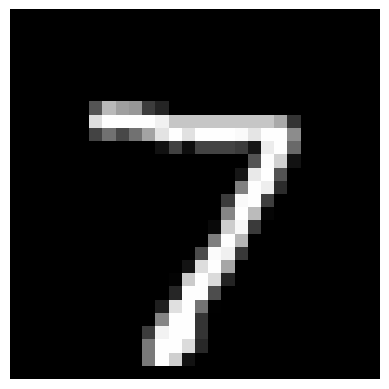

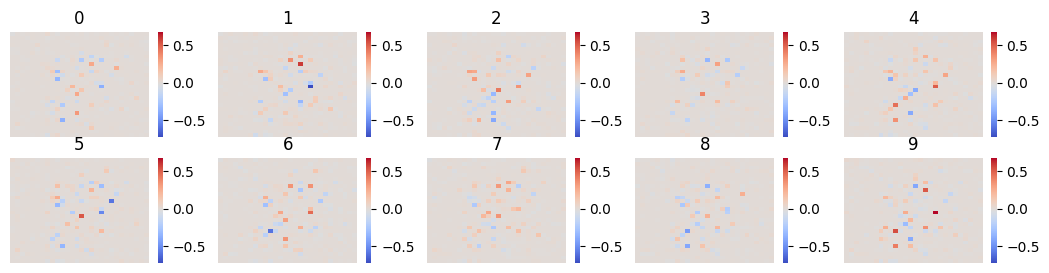

<BarContainer object of 10 artists>

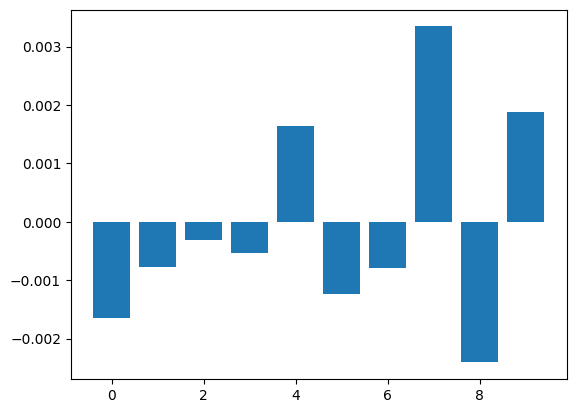

In [29]:
preds = []
idx=0
# model.dropout=0
# model.feature_dropout=0
# model.dropout_layer = torch.nn.Dropout(p=0)

# np.random.seed()
# torch.random.seed()

# for i in range(784):
#     model.models[0].feature_nns[i].dropout = torch.nn.Dropout(p=0)

model.models[0].eval()

X = torch.tensor([test_images[idx]], requires_grad=False, dtype=torch.float)
# for single_model in model.models:
#     preds.append(single_model.calc_outputs(X))
preds = model.models[0].calc_outputs(X)
label_pred = model.predict_proba(X)
print(np.argmax(label_pred))

preds = [x.squeeze().detach().numpy() for x in preds]

preds = np.array(preds)
preds = preds.T

image = test_images[idx].reshape(28,28)
plt.imshow(image, cmap="gray")
plt.axis("off")

fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(13,3))
axs = axs.flatten()

vmax = np.max(preds)
vmin = np.min(preds)
means = []
for i in range(10):
    image_importance = preds[i].reshape(28,28) 
    means.append(np.mean(image_importance))
    most_important_idx = np.argmax(np.array([x.item() for x in preds[0]]))
    #image_importance[abs(image_importance) < 0.08] = 0

#     sns.heatmap(image, cmap="gray", ax=axs[0])
    sns.heatmap(image_importance, cmap="coolwarm", ax=axs[i], vmin=vmin, vmax=vmax)

#     axs[0].axis("off")
    axs[i].axis("off")
    axs[i].set_title(i)
    
plt.show()
plt.bar(np.arange(0,10), means)

In [ ]:
# model.models[0].save("epoch38_single_nam.h5")
# print(model.models[0]._bias.detach().numpy().squeeze())

# from nam.models.saver import Checkpointer

# checkpointer = Checkpointer(log_dir="output_long/0") # only one model
# checkpointer.save(model.models[0], "best")

### Loading saved checkpoint

In [ ]:
# model = MultiTaskNAMClassifier(
#             num_learners=1,
#             patience=60,
#             num_epochs=100,
#             num_subnets=1,
#             metric='accuracy',
#             monitor_loss=True,
#             early_stop_mode='max',
#             n_jobs=1,
#             random_state=random_state,
#             loss_func=torch.nn.functional.cross_entropy
#         )

# model.load_checkpoints("output_long")

# model.models[0].eval()
# pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))
# test_labels_sub_labels = np.argmax(test_labels_sub[:100], axis=-1)
# np.mean(pred_labels.detach().numpy()==test_labels_sub_labels[:100])

In [22]:
preds.shape

(10, 784)

In [23]:
activations = []
test_idx = most_important_idx

test_image = np.zeros(test_images[idx].shape)

for i in tqdm(range(255)):
    i/=255
    test_image[:] = i
    X = torch.tensor([test_image], requires_grad=False, dtype=torch.float)
    for single_model in model.models:
        model_out = single_model.calc_outputs(X)
        model_out = np.array([x.detach().numpy().squeeze() for x in model_out])
        activations.append(model_out)

100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:33<00:00,  7.62it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.32it/s]


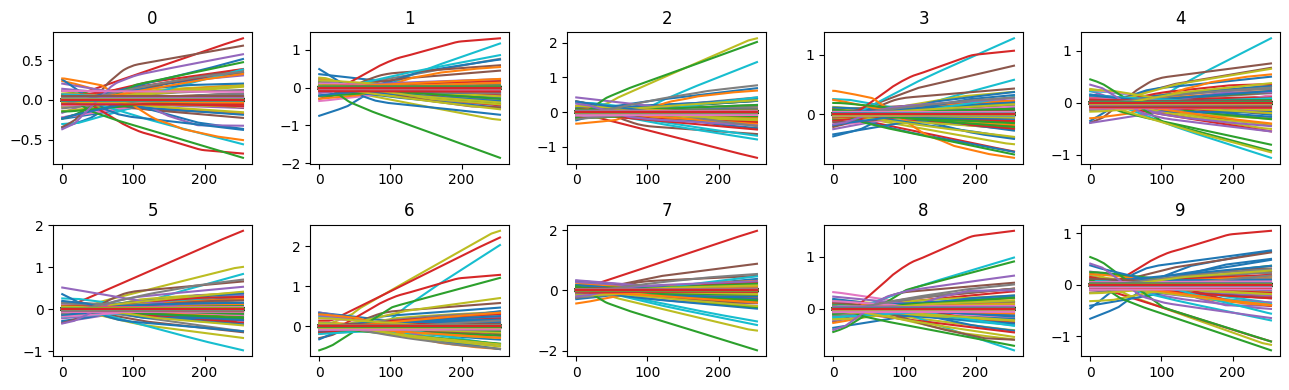

In [24]:
activations = np.array(activations)
activations_reshaped = activations.transpose((2,0,1))

fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(13,4))
axs = axs.flatten()

for i in tqdm(range(10)):
    axs[i].set_title(i)
    for act in activations_reshaped[i].T:
        axs[i].plot(act)

plt.tight_layout()
# activations_reshaped[0]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.72it/s]


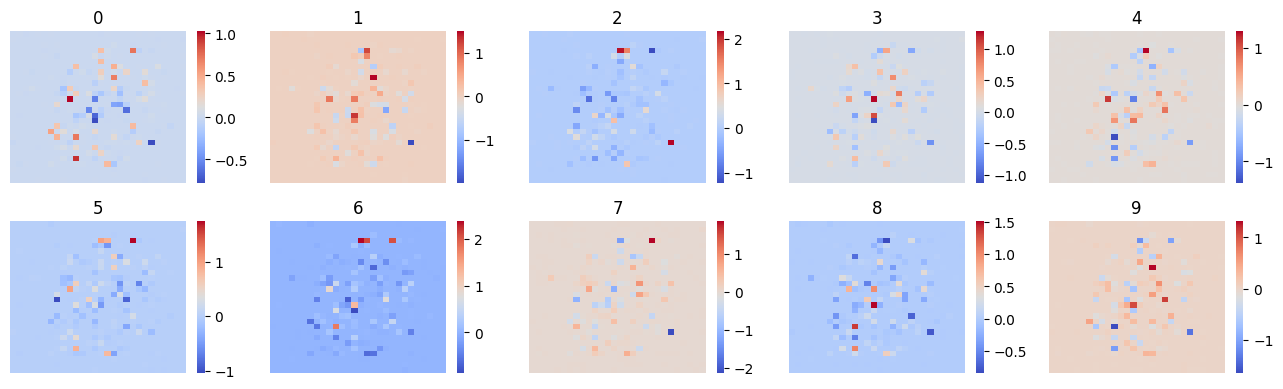

In [27]:
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(13,4))
axs = axs.flatten()


vmin=np.min(activations_reshaped)
vmax=np.max(activations_reshaped)

vmax = abs(max(vmin, vmax))
vmin = -vmax

for i in tqdm(range(10)):
    axs[i].set_title(i)
    actT = activations_reshaped[i].T
#     cols = np.std(actT, axis=1)
#     cols = np.max(actT, axis=1)-np.min(actT[:], axis=1)
    cols = actT[:,-1]-actT[:,0]
#     cols[cols>0.33]=1
#     cols[cols<=0.33]=0
#     sns.heatmap(cols.reshape(28,28), ax=axs[i], vmin=vmin, vmax=vmax, cmap="coolwarm")
    sns.heatmap(cols.reshape(28,28), ax=axs[i], cmap="coolwarm")
    axs[i].axis("off")
plt.tight_layout()



In [30]:

from nam.models.saver import Checkpointer

checkpointer = Checkpointer(log_dir="distilled/0") # only one model
checkpointer.save(model.models[0], "best")

# model = MultiTaskNAMClassifierDistill(
#             num_learners=1,
#             patience=60,
#             num_epochs=10,
#             num_subnets=1,
#             metric='accuracy',
#             monitor_loss=True,
#             early_stop_mode='max',
#             n_jobs=1,
#             random_state=random_state,
#             loss_func=torch.nn.functional.cross_entropy,
#             teacher_model=CNN.model,
#             teacher_preprocess=reshape_to_img
#         )


# model.load_checkpoints("distilled")

# model.models[0].eval()
# pred = torch.nn.functional.softmax(torch.tensor(model.predict_proba(test_images_sub[:100])))
# test_labels_sub_labels = np.argmax(test_labels_sub[:100], axis=-1)
# np.mean(pred_labels.detach().numpy()==test_labels_sub_labels[:100])

'distilled/0\\ckpts\\model-best.pt'